#### Stop any previous spark session that might be running 

In [86]:
try:
    sc.stop()
except:
    print('no sc to stop')

#### Start a new spark session

In [87]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc = SparkContext()

spark = SparkSession(sparkContext= sc)

Prediction of Churn is True or False: Using Telecom Dataset and making predictions using Classification Algorithms. Displaying Classification Metrics and compare algorithm’s Classification Report and Confusion Matrix. Make predictions if a customer is likely to leave the network provider or Not. 

Churn = False: Customer staying with current telecom network provider.
Churn = True: Customer left the current telecom network provider.

Dataset Link:
https://github.com/ammishra08/MachineLearning/blob/master/Datasets/churn-bigml-20.csv


#### Load dataset in pandas and spark respectively

In [88]:
import pandas as pd

df2 = pd.read_csv('https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/churn-bigml-20.csv', sep = ',')
df2.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [89]:
from pyspark import SparkFiles

url = "https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/churn-bigml-20.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv("file://"+SparkFiles.get("churn-bigml-20.csv"), sep = ',', header=True, inferSchema= True)
df.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

#### A look at the datatypes we have

In [90]:
df.cache()
df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



#### Changing the target variable innto binary for easy classification

In [91]:
import numpy as np
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType

df = df.drop('State', 'International plan', 'Voice mail plan')
df = df.withColumn('Churn', when(df.Churn == "False", '0').otherwise('1'))
df = df.withColumn("Churn", df["Churn"].cast(IntegerType()))

#### Statistics summary of the features

In [92]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,667,102.84107946026987,40.8194801730225,1,232
Area code,667,436.15742128935534,41.783304688566986,408,510
Number vmail messages,667,8.407796101949025,13.994479792227365,0,51
Total day minutes,667,180.94812593703156,55.508627757238074,25.9,334.3
Total day calls,667,100.93703148425787,20.3967904839353,30,165
Total day charge,667,30.761769115442267,9.436463453602562,4.4,56.83
Total eve minutes,667,203.35532233883055,49.7192684838294,48.1,361.8
Total eve calls,667,100.4767616191904,18.94826169676192,37,168
Total eve charge,667,17.285262368815594,4.22616013339548,4.09,30.75


#### Define confusion Matrix for evaluation

In [93]:
def compute_corr_matrix(df, method = 'pearson'):
    df_rdd = df.rdd.map( lambda r: r[0:] )
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat, columns=df.columns, index=df.columns)
    return(corr_mat_df)

#### Creating feature of the independent variables

In [95]:
f_cols=df.columns
f_cols.remove('Churn')
assembler = VectorAssembler(inputCols=f_cols, outputCol='features')

# convert input cols into features
df = assembler.transform(df)
df.select('features').show(5, truncate=False)

+---------------------------------------------------------------------------------------+
|features                                                                               |
+---------------------------------------------------------------------------------------+
|[117.0,408.0,0.0,184.5,97.0,31.37,351.6,80.0,29.89,215.8,90.0,9.71,8.7,4.0,2.35,1.0]   |
|[65.0,415.0,0.0,129.1,137.0,21.95,228.5,83.0,19.42,208.8,111.0,9.4,12.7,6.0,3.43,4.0]  |
|[161.0,415.0,0.0,332.9,67.0,56.59,317.8,97.0,27.01,160.6,128.0,7.23,5.4,9.0,1.46,4.0]  |
|[111.0,415.0,0.0,110.4,103.0,18.77,137.3,102.0,11.67,189.6,105.0,8.53,7.7,6.0,2.08,2.0]|
|[49.0,510.0,0.0,119.3,117.0,20.28,215.1,109.0,18.28,178.7,90.0,8.04,11.1,1.0,3.0,1.0]  |
+---------------------------------------------------------------------------------------+
only showing top 5 rows



#### A count plot of the target variable( count of Churn and count of Not-Churn)

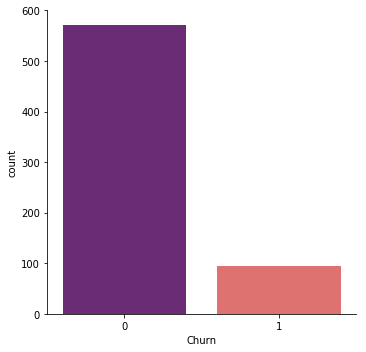

In [96]:
sns.catplot(x='Churn', kind='count', data=df.toPandas(), palette='magma')

#### Count & Proportion of Churn

In [97]:
### Train & test split
train, test = df.randomSplit([.8,.2],  seed=2)#seed=9991)

train = train.withColumn("Churn", train["Churn"].cast(IntegerType()))
test = test.withColumn("Churn", test["Churn"].cast(IntegerType()))

# Weighting for unequal sample size

dataset_size= float(train.select("Churn").count())
num_positives= train.select("Churn").where("Churn == 0").count()
per_two = (float(num_positives)/dataset_size)

dataset_size, num_positives, per_two

print("The number of ones are %s" % num_positives)
print("Percentage of ones %s" % per_two)

num_negatives = dataset_size - num_positives
balance_ratio = num_negatives / dataset_size

print("balance_ration = %s" % balance_ratio)

The number of ones are 465
Percentage of ones 0.8595194085027726
balance_ration = 0.14048059149722736


#### Defining Class Weights (Unbalanced dataset)

In [98]:
train = train.withColumn("classWeights", when(train.Churn == '0', balance_ratio).otherwise(1 - balance_ratio))
train.select("classWeights").show()

+-------------------+
|       classWeights|
+-------------------+
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
|0.14048059149722736|
| 0.8595194085027726|
+-------------------+
only showing top 20 rows



#### Logistic Regresion
A look into the top 20 results of the actual results to the predicted results of the model.

In [99]:
from pyspark.ml.classification import LogisticRegression

#Weighted columns
logit_model = LogisticRegression(labelCol='Churn', featuresCol='features', weightCol='classWeights', maxIter=20)

# when training the algorithm always use training samples, don't apply to entire dataset
model = logit_model.fit(train)

predict_train = model.transform(train)
predict_test = model.transform(test)

predict_test.select("Churn", "prediction").show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



Count of number of times the model accurately predict the results, inaccurately predict the results and the proportion of accurately predicted results

In [100]:
predict_test.where("Churn == prediction").count(),\
predict_test.where("Churn != prediction").count(),\
predict_test.where("Churn == prediction").count()/predict_test.count(),

(100, 26, 0.7936507936507936)

#### Accuracy of Model

In [101]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Churn", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predict_test)
print("Accuracy: ", (accuracy))

Accuracy:  0.7936507936507936


#### Confusion Matrix for Model Evaluation

[[87 20]
 [ 6 13]]


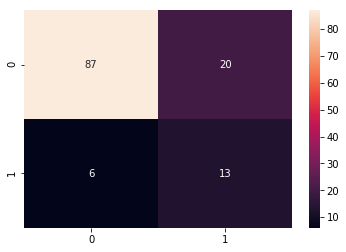

In [103]:
from sklearn.metrics import confusion_matrix

y_true = predict_test.select('Churn').toPandas()
#y_true = y_true.toPandas()

y_pred = predict_test.select('prediction').toPandas()
#y_pred = y_pred.toPandas

confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)
sns.heatmap(confusion_mat, annot=True)

#### End Spark Session

In [104]:
spark.stop()
sc.stop()